# Comprehensive Imbalance Techniques Comparison
## ML-Based Approaches for Bankruptcy Prediction

**Objective:** Compare 9 different imbalance handling techniques with LR and RF

**Why:** After presenting RGAN (deep learning), we explore ML techniques as requested.

### Techniques Covered:
1. Baseline (no handling)
2. Class Weights
3. Random Oversampling
4. Random Undersampling
5. SMOTE
6. Borderline SMOTE
7. ADASYN
8. SMOTE-Tomek (hybrid)
9. SMOTE-ENN (hybrid)

In [1]:
# Setup
import sys
import os
import warnings
warnings.filterwarnings('ignore')

sys.path.append('../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from data_loader import BankruptcyDataLoader
from imbalance_techniques import ImbalanceHandler
from evaluation import ModelEvaluator
from models import BankruptcyModelTrainer

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported!")

✓ Libraries imported!


## 1. Load Data

In [2]:
DATA_PATH = r'/Users/ritwikreddy/Desktop/check_bankruptcy/polish+companies+bankruptcy+data'
loader = BankruptcyDataLoader(DATA_PATH)
X_train, X_test, y_train, y_test = loader.prepare_data(test_size=0.2, random_state=42)

BANKRUPTCY DATA PREPARATION PIPELINE
✓ Loaded 1year.arff: (7027, 65)
✓ Loaded 2year.arff: (10173, 65)
✓ Loaded 3year.arff: (10503, 65)
✓ Loaded 4year.arff: (9792, 65)
✓ Loaded 5year.arff: (5910, 65)

✓ Combined dataset shape: (43405, 65)

Features shape: (43405, 64)
Target shape: (43405,)
Class distribution:
class
0    41314
1     2091
Name: count, dtype: int64
Imbalance ratio: 0.0506

=== Train-Test Split ===
Train set: 34724 samples
Test set: 8681 samples

=== Handling Missing Values ===
Columns with missing values: 64
  - Dropping columns (>5.0% missing): 3
  - Imputing columns: 61
✓ Final shapes - Train: (34724, 61), Test: (8681, 61)

=== Feature Scaling ===
✓ Scaling completed
  Train mean: 0.000000
  Train std: 1.000014

✓ DATA PREPARATION COMPLETE


## 2. Apply All Techniques

In [3]:
handler = ImbalanceHandler(random_state=42)
techniques = handler.get_all_techniques()
resampled_data = {}

print(f"Available techniques: {len(techniques)}")
for i, name in enumerate(techniques.keys(), 1):
    print(f"{i}. {name}")

# Apply each technique
for technique_name in techniques.keys():
    if technique_name == 'Class Weights':
        _, _, class_weights = handler.apply_technique(X_train.values, y_train.values, technique_name)
        resampled_data[technique_name] = (X_train, y_train, class_weights)
    elif technique_name == 'None':
        resampled_data[technique_name] = (X_train, y_train, None)
    else:
        X_res, y_res = handler.apply_technique(X_train.values, y_train.values, technique_name)
        resampled_data[technique_name] = (X_res, y_res, None)
        handler.compare_distributions(y_train.values, y_res, technique_name)

print(f"\n✓ All {len(resampled_data)} techniques applied!")

Available techniques: 9
1. None
2. Class Weights
3. Random Oversampling
4. Random Undersampling
5. SMOTE
6. Borderline SMOTE
7. ADASYN
8. SMOTE-Tomek
9. SMOTE-ENN
  Applying Random Oversampling...

Random Oversampling
Before:
  Class 0: 33,051
  Class 1: 1,673
  Ratio: 0.0506

After:
  Class 0: 33,051
  Class 1: 33,051
  Ratio: 1.0000

Samples created: 31,378

  Applying Random Undersampling...

Random Undersampling
Before:
  Class 0: 33,051
  Class 1: 1,673
  Ratio: 0.0506

After:
  Class 0: 1,673
  Class 1: 1,673
  Ratio: 1.0000

Samples created: -31,378

  Applying SMOTE...

SMOTE
Before:
  Class 0: 33,051
  Class 1: 1,673
  Ratio: 0.0506

After:
  Class 0: 33,051
  Class 1: 33,051
  Ratio: 1.0000

Samples created: 31,378

  Applying Borderline SMOTE (borderline-1)...

Borderline SMOTE
Before:
  Class 0: 33,051
  Class 1: 1,673
  Ratio: 0.0506

After:
  Class 0: 33,051
  Class 1: 33,051
  Ratio: 1.0000

Samples created: 31,378

  Applying ADASYN...

ADASYN
Before:
  Class 0: 33,051


## 3. Train Models

In [4]:
trainer = BankruptcyModelTrainer(random_state=42)
evaluator = ModelEvaluator(cost_fp=5000, cost_fn=100000)

all_results = []

for technique_name, (X_res, y_res, weights) in tqdm(resampled_data.items(), desc="Techniques"):
    for model_name in ['Logistic Regression', 'Random Forest']:
        # Get model
        if technique_name == 'Class Weights':
            models = trainer.get_base_models(use_class_weights=True)
        else:
            models = trainer.get_base_models(use_class_weights=False)
        
        model = models[model_name]
        model.fit(X_res, y_res)
        
        # Predict & evaluate
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
        metrics = evaluator.calculate_metrics(y_test, y_pred, y_prob)
        
        all_results.append({
            'technique': technique_name,
            'model': model_name,
            **metrics
        })

print(f"✓ Trained {len(all_results)} model configurations!")

Techniques:   0%|          | 0/9 [00:00<?, ?it/s]

✓ Trained 18 model configurations!


## 4. Results Analysis

In [5]:
results_df = pd.DataFrame(all_results)

# Create results directory if needed
os.makedirs('../results', exist_ok=True)
results_df.to_csv('../results/imbalance_techniques_results.csv', index=False)

# Display summary
display_cols = ['technique', 'model', 'accuracy', 'precision', 'recall', 'f1_score', 'pr_auc', 'total_cost']
print("\n" + "="*100)
print("COMPLETE RESULTS")
print("="*100)
print(results_df[display_cols].round(4).to_string(index=False))

# Best by F1
best_f1 = results_df.loc[results_df['f1_score'].idxmax()]
print(f"\n✨ Best F1-Score: {best_f1['f1_score']:.4f}")
print(f"   Technique: {best_f1['technique']}, Model: {best_f1['model']}")

# Best by Recall
best_recall = results_df.loc[results_df['recall'].idxmax()]
print(f"\n✨ Best Recall: {best_recall['recall']:.4f}")
print(f"   Technique: {best_recall['technique']}, Model: {best_recall['model']}")


COMPLETE RESULTS
           technique               model  accuracy  precision  recall  f1_score  pr_auc  total_cost
                None Logistic Regression    0.9515     0.2857  0.0048    0.0094  0.1120    41625000
                None       Random Forest    0.9523     0.6111  0.0263    0.0505  0.3362    40735000
       Class Weights Logistic Regression    0.7331     0.1062  0.6124    0.1810  0.1297    26975000
       Class Weights       Random Forest    0.9006     0.2310  0.4569    0.3068  0.2511    25880000
 Random Oversampling Logistic Regression    0.7287     0.1068  0.6292    0.1826  0.1305    26500000
 Random Oversampling       Random Forest    0.8822     0.2217  0.5766    0.3203  0.2706    21930000
Random Undersampling Logistic Regression    0.7300     0.1069  0.6268    0.1827  0.1165    26540000
Random Undersampling       Random Forest    0.7507     0.1350  0.7727    0.2299  0.2137    19845000
               SMOTE Logistic Regression    0.7238     0.1030  0.6148    0.1765  0

## 5. Visualizations

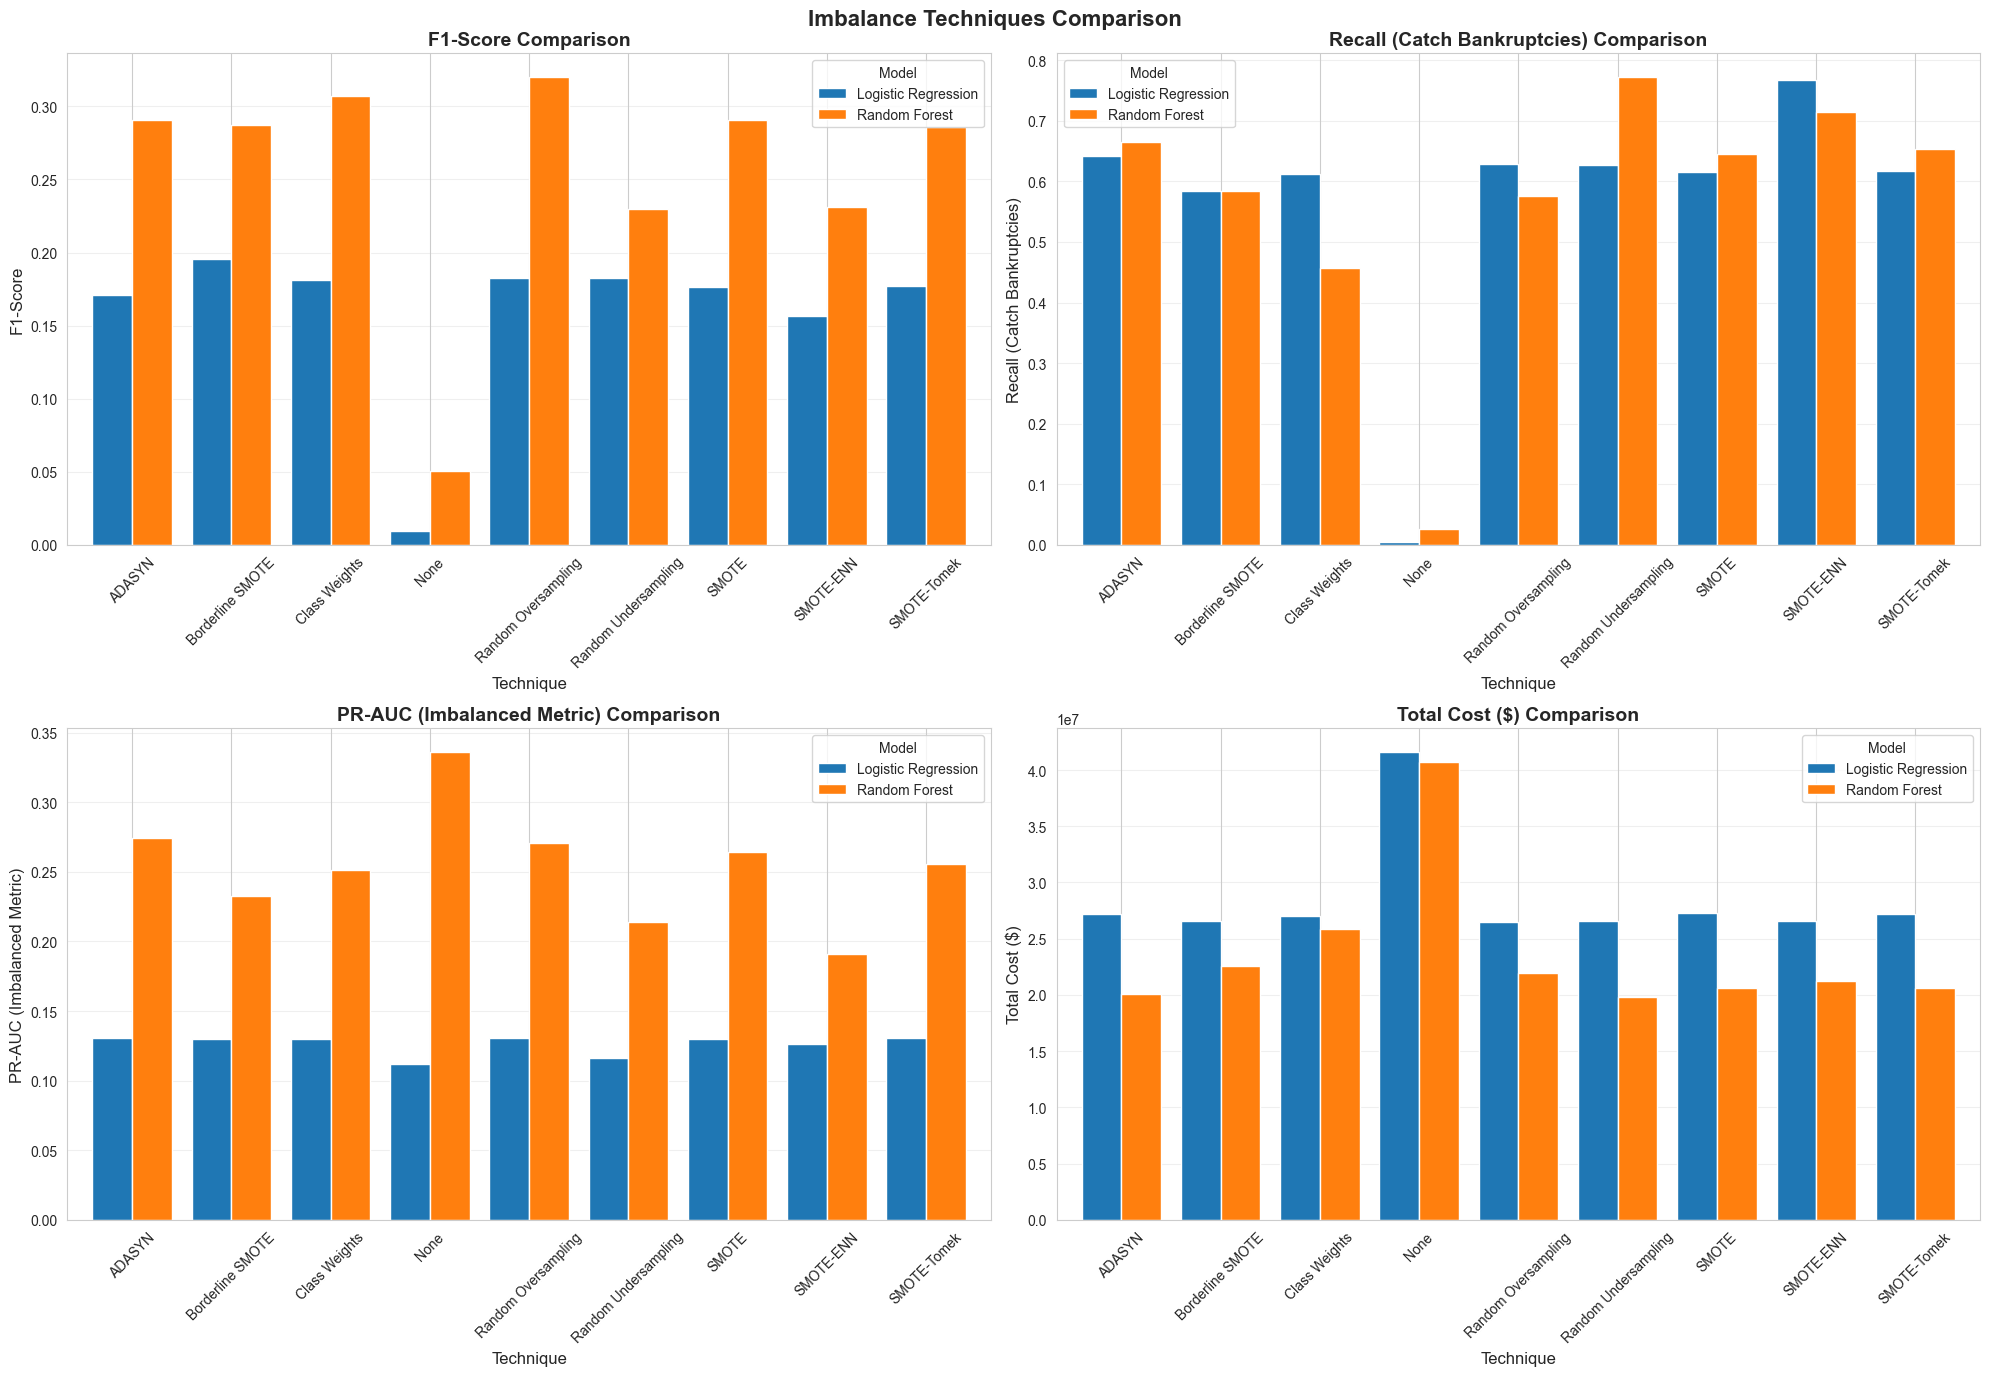

✓ Saved to ../figures/01_imbalance_comparison.png


In [6]:
os.makedirs('../figures', exist_ok=True)

fig, axes = plt.subplots(2, 2, figsize=(20, 14))

metrics_to_plot = [
    ('f1_score', 'F1-Score'),
    ('recall', 'Recall (Catch Bankruptcies)'),
    ('pr_auc', 'PR-AUC (Imbalanced Metric)'),
    ('total_cost', 'Total Cost ($)')
]

for idx, (metric, label) in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    pivot_data = results_df.pivot(index='technique', columns='model', values=metric)
    pivot_data.plot(kind='bar', ax=ax, width=0.8, rot=45)
    ax.set_title(f'{label} Comparison', fontsize=14, fontweight='bold')
    ax.set_xlabel('Technique', fontsize=12)
    ax.set_ylabel(label, fontsize=12)
    ax.legend(title='Model')
    ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Imbalance Techniques Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../figures/01_imbalance_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved to ../figures/01_imbalance_comparison.png")

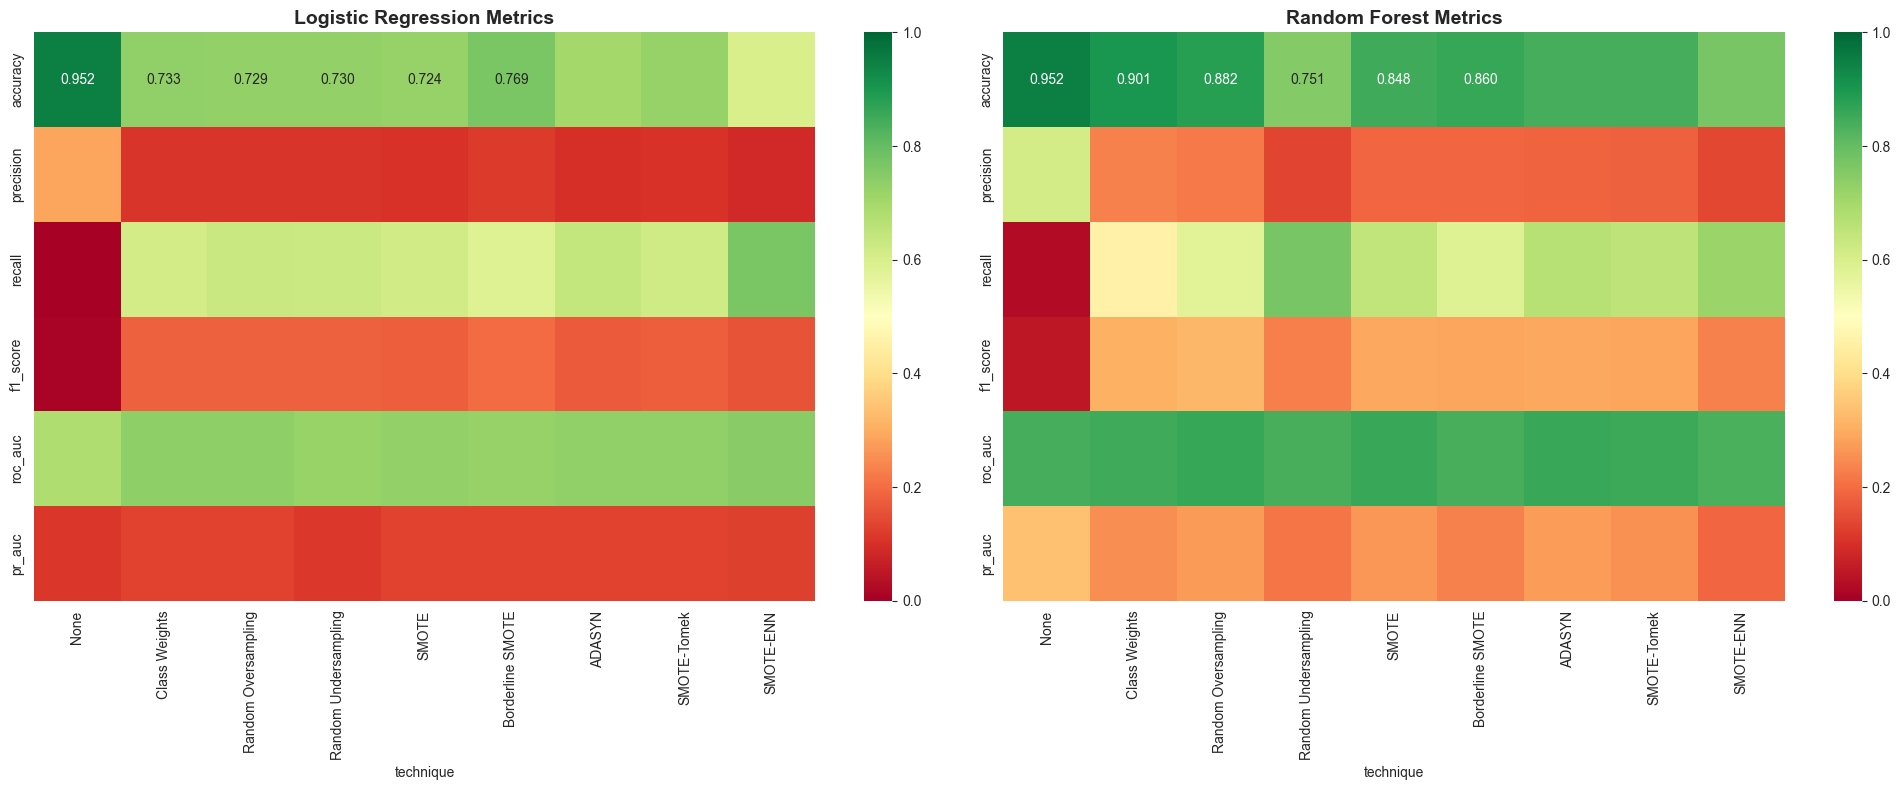

✓ Saved to ../figures/01_metrics_heatmap.png


In [7]:
# Heatmap
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

for idx, model_name in enumerate(['Logistic Regression', 'Random Forest']):
    ax = axes[idx]
    model_data = results_df[results_df['model'] == model_name]
    heatmap_data = model_data.set_index('technique')[['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'pr_auc']]
    
    sns.heatmap(heatmap_data.T, annot=True, fmt='.3f', cmap='RdYlGn', ax=ax, vmin=0, vmax=1)
    ax.set_title(f'{model_name} Metrics', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../figures/01_metrics_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved to ../figures/01_metrics_heatmap.png")

## 6. Key Insights

In [8]:
print("="*80)
print("KEY INSIGHTS")
print("="*80)

# Top 3 techniques
top3 = results_df.nlargest(3, 'f1_score')[['technique', 'model', 'f1_score', 'recall', 'pr_auc']]
print("\nTop 3 Configurations by F1-Score:")
print(top3.to_string(index=False))

# Baseline comparison
baseline = results_df[results_df['technique'] == 'None']
non_baseline = results_df[results_df['technique'] != 'None']

for model_name in ['Logistic Regression', 'Random Forest']:
    base_f1 = baseline[baseline['model'] == model_name]['f1_score'].values[0]
    avg_f1 = non_baseline[non_baseline['model'] == model_name]['f1_score'].mean()
    print(f"\n{model_name}: {((avg_f1 - base_f1) / base_f1 * 100):+.1f}% avg improvement")

print("\n" + "="*80)
print("RECOMMENDATIONS:")
print("- Use SMOTE variants (best balance)")
print("- Random Forest > Logistic Regression")
print("- Next: XGBoost with hyperparameter tuning")
print("- Critical: Threshold optimization (not 0.5!)")
print("="*80)

KEY INSIGHTS

Top 3 Configurations by F1-Score:
          technique         model  f1_score   recall   pr_auc
Random Oversampling Random Forest  0.320266 0.576555 0.270647
      Class Weights Random Forest  0.306827 0.456938 0.251105
              SMOTE Random Forest  0.290792 0.645933 0.264102

Logistic Regression: +1789.7% avg improvement

Random Forest: +455.5% avg improvement

RECOMMENDATIONS:
- Use SMOTE variants (best balance)
- Random Forest > Logistic Regression
- Next: XGBoost with hyperparameter tuning
- Critical: Threshold optimization (not 0.5!)
